In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from scipy import stats
import math
import os
from mplsoccer import PyPizza, add_image
import warnings
from urllib.request import urlopen
import matplotlib.font_manager as fm
warnings.filterwarnings("ignore", category=FutureWarning)

In [216]:
class SoccerPlot:
    font_normal = os.path.join('..', 'fonts', 'Lora-VariableFont_wght.ttf')
    font_italic = os.path.join('..', 'fonts', 'Lora-Italic-VariableFont_wght.ttf')
    font_bold = os.path.join('..', 'fonts', 'Oswald-VariableFont_wght.ttf')
    font_normal_prop = fm.FontProperties(fname=font_normal)
    font_italic_prop = fm.FontProperties(fname=font_italic)
    font_bold_prop = fm.FontProperties(fname=font_bold)

    def __init__(self, df, cols_filter) -> None:
        self.df = df
        self.cols_filter = cols_filter

    def get_player(self, player_name, dataframe, cols_filter):
        player = dataframe.loc[(dataframe['Player'] == player_name)].reset_index()
        player = player[cols_filter]
        return list(player.loc[0])

    def calculate_percintiles(self, params, dataframe, player):
        values = []
        for x in range(len(params)):
            values.append(math.floor(stats.percentileofscore(dataframe[params[x]], player[x])))
        return values

    def get_params_list(self, df: pd.DataFrame, cols_filter):
        params_df = df[cols_filter]
        params = list(params_df.columns)
        return params
    
    def round_image(self, img):
        width, height = img.size

        # Create a circular mask with a perfect circle
        mask = Image.new('L', (width, height), 0)
        draw = ImageDraw.Draw(mask)
        
        min_dim = min(width, height)
        circle_radius = min_dim // 2
        circle_center = (width // 2, height // 2)
        
        draw.ellipse([(circle_center[0] - circle_radius, circle_center[1] - circle_radius),
                    (circle_center[0] + circle_radius, circle_center[1] + circle_radius)],
                    fill=255)
        result = Image.new('RGBA', (width, height), (0, 0, 0, 0))
        result.paste(img, (0, 0), mask)

        return result
    
    def create_pizza_plot(self, values, params, title, subtitle, data_credit, your_credit, player_image, team_image):

        # instantiate PyPizza class
        baker = PyPizza(
            params=params,                  # list of params
            background_color="#222222",
            straight_line_color="#000000",  # color for straight lines
            straight_line_lw=1,             # linewidth for straight lines
            last_circle_lw=1,               # linewidth of last circle
            other_circle_lw=1,              # linewidth for other circles
            other_circle_ls="-.",           # linestyle for other circles
            inner_circle_size=20            # increase the circle size
        )
        slice_colors = ["#D70232"]*len(self.cols_filter)
        # plot pizza
        fig, ax = baker.make_pizza(
            values,              # list of values
            figsize=(8, 8),      # adjust figsize according to your need
            slice_colors=slice_colors,
            value_bck_colors=slice_colors,
            color_blank_space="same",
            param_location=110,  # where the parameters will be added
            kwargs_slices=dict(
                facecolor="#D70232", edgecolor="#000000",
                zorder=2, linewidth=1
            ),                   # values to be used when plotting slices
            kwargs_params=dict(
                color="#F2F2F2", fontsize=12,
                fontproperties=self.font_normal_prop,
                va="center"
            ),                   # values to be used when adding parameter
            kwargs_values=dict(
                color="#F2F2F2", fontsize=12,
                fontproperties=self.font_normal_prop,
                zorder=3,
                bbox=dict(
                    edgecolor="#000000", facecolor="#D70232",
                    boxstyle="round,pad=0.2", lw=1
                )
            )                    # values to be used when adding parameter-values
        )

        # add title
        fig.text(
            0.515, 0.975, title, size=16,
            ha="center", fontproperties=self.font_bold_prop, 
            color="#F2F2F2"
        )

        # add subtitle
        fig.text(
            0.515, 0.953,
            subtitle,
            size=13,
            ha="center", fontproperties=self.font_bold_prop,
            color="#F2F2F2"
        )

        fig.text(
            0.99, 0.02, f"{data_credit}\n{your_credit}", size=9,
            fontproperties=self.font_italic_prop,
            color="#F2F2F2",
            ha="right"
        )
        # add image
        if (player_image != None) and (team_image != None):
            player_image = self.round_image(player_image)
            ax_image = add_image(player_image, fig, left=0.4, bottom=0.38, width=0.224, height=0.228)
            ax_image = add_image(team_image, fig, left=0., bottom=1, width=0.08, height=0.08)

        return fig, ax
    
    def generate_simple_pizza_plot(self, player_name, title, subtitle, data_credit, your_credit, player_image, team_image):
        params = self.get_params_list(self.df, self.cols_filter)
        player = self.get_player(player_name, self.df, self.cols_filter)
        values = self.calculate_percintiles(params, self.df, player)

        self.create_pizza_plot(values, params, title, subtitle, data_credit, your_credit, player_image, team_image)
        plt.show()

# Example usage

In [217]:
BASE_DIR = os.path.join('..', 'data')
ENGINEERED_DIR = os.path.join(BASE_DIR, 'engineered', '2023', 'brazil_serie_A')
std_csv = os.path.join(ENGINEERED_DIR, 'squad_std_stats.csv')
df = pd.read_csv(std_csv)

In [218]:
df = df.loc[df['Pos'].str.contains('FW')]


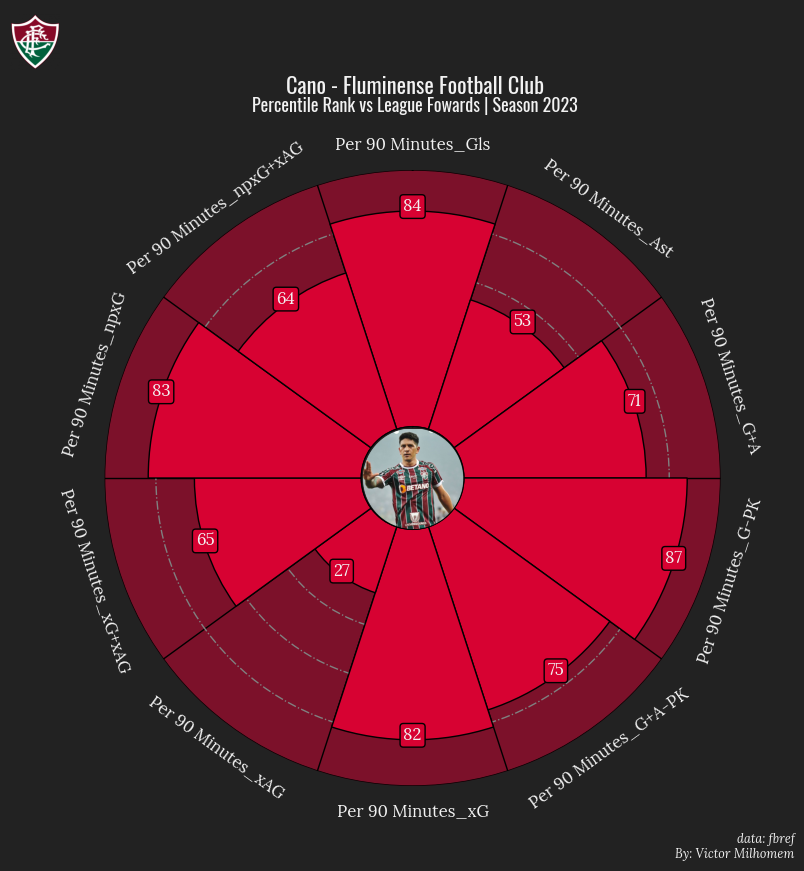

In [219]:
cols_filter = df.filter([
                            'Per 90 Minutes_Gls', 'Per 90 Minutes_Ast',
       'Per 90 Minutes_G+A', 'Per 90 Minutes_G-PK', 'Per 90 Minutes_G+A-PK',
       'Per 90 Minutes_xG', 'Per 90 Minutes_xAG', 'Per 90 Minutes_xG+xAG',
       'Per 90 Minutes_npxG', 'Per 90 Minutes_npxG+xAG'
]).columns

plot = SoccerPlot(df, cols_filter)
title = "Cano - Fluminense Football Club"
subtitle = "Percentile Rank vs League Fowards | Season 2023"
player_image = Image.open(urlopen('https://tmssl.akamaized.net/images/foto/galerie/german-cano-1695926165-117979.jpeg?lm=1695926174'))
team_image = Image.open(urlopen('https://tmssl.akamaized.net/images/wappen/head/2462.png?lm=1648225934'))
plot.generate_simple_pizza_plot('Germán Cano', title, subtitle, 'data: fbref', 'By: Victor Milhomem', player_image, team_image)